**Sources:**

- Weather data Nakagawa/Asahikawa -- http://www.data.jma.go.jp/gmd/risk/obsdl/index.php
- Global River Thawing -- http://nsidc.org/data/lake_river_ice/freezethaw.html
- Canada Weather -- https://climate.weather.gc.ca/climate_data/daily_data_e.html
- Teshio river flow -- http://www1.river.go.jp/cgi-bin/SiteInfo.exe?ID=301011281104120
- Paper Teshio -- https://www.hkd.mlit.go.jp/ky/jg/gijyutu/splaat000001t52c-att/splaat000001t5b9.pdf


# Import packages

In [1048]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import re
import seaborn as sns

print(tf.__version__)

## Make NumPy printouts easier to ready
np.set_printoptions(precision=3, suppress=True)

2.6.2


In [1049]:
BASEDIR_DATA = 'data/'

# DATA PREPARATION
## Weather Data
Read weather data for each country separately before standardising

In [1050]:
BASEDIR_WEATHER = BASEDIR_DATA + 'weather_data'

def weather_csv_import(country):
    BASEDIR_COUNTRY = "{}/{}".format(BASEDIR_WEATHER, country) 

    rivers = [x[1] for x in os.walk(BASEDIR_COUNTRY)][0]

    df_weather_country = pd.DataFrame()

    for river in rivers: 
        print("Reading data for river {} in {}".format(river, country))

        BASEDIR_RIVER = "{}/{}".format(BASEDIR_COUNTRY, river)
        river_data_files = [x[2] for x in os.walk(BASEDIR_RIVER)][0]
        for data_file in river_data_files:
            if '.csv' in data_file:
                fpath = "{}/{}".format(BASEDIR_RIVER, data_file)
                df_weather_river = pd.read_csv(fpath)
                df_weather_river['Country'] = country 
                df_weather_river['River_Code'] = river
                df_weather_country = pd.concat([df_weather_country, df_weather_river])
    return df_weather_country

### Canada

In [1051]:
## Import CSV data 
df_weather_can = weather_csv_import('CANADA')

## Check resulting dataframe
pd.concat([df_weather_can.head(3), df_weather_can.tail(3)])

Reading data for river MF83 in CANADA
Reading data for river WRS23 in CANADA
Reading data for river WRS21 in CANADA
Reading data for river WRS3 in CANADA


,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Country,River_Code
0,-77.88,45.07,BANCROFT AUTO,616I001,1999-01-01,1999,1,1,NaN,-14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANADA,MF83
1,-77.88,45.07,BANCROFT AUTO,616I001,1999-01-02,1999,1,2,NaN,-14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANADA,MF83
2,-77.88,45.07,BANCROFT AUTO,616I001,1999-01-03,1999,1,3,NaN,-2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANADA,MF83
362,-99.95,49.91,BRANDON A,5010480,1994-12-29,1994,12,29,NaN,-4.0,...,1.5,NaN,5.0,NaN,30.0,NaN,44,E,CANADA,WRS3
363,-99.95,49.91,BRANDON A,5010480,1994-12-30,1994,12,30,NaN,-8.4,...,0.0,T,7.0,NaN,29.0,NaN,46,E,CANADA,WRS3
364,-99.95,49.91,BRANDON A,5010480,1994-12-31,1994,12,31,NaN,-12.6,...,0.2,NaN,7.0,NaN,NaN,NaN,<31,NaN,CANADA,WRS3


In [1052]:
## Select columns for standardisation
df_weather_CAN = df_weather_can[['Country', 'River_Code', 'Station Name', 
               'Latitude (y)', 'Longitude (x)', 'Date/Time', 
               'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
               'Total Precip (mm)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)']]
df_weather_CAN.columns = ['COUNTRY', 'RIVER_CODE', 'STATION', 'LAT', 'LON', 'DATE', 
               'TEMP_MAX', 'TEMP_MIN', 'TEMP_MEAN', 'PRECIPITATION', 'WIND_DIR', 'WIND_SPEED']
df_weather_CAN.head()

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_DIR,WIND_SPEED
0,CANADA,MF83,BANCROFT AUTO,45.07,-77.88,1999-01-01,-14.9,-33.8,-24.4,NaN,NaN,NaN
1,CANADA,MF83,BANCROFT AUTO,45.07,-77.88,1999-01-02,-14.9,-34.7,-24.8,NaN,NaN,NaN
2,CANADA,MF83,BANCROFT AUTO,45.07,-77.88,1999-01-03,-2.9,-14.9,-8.9,NaN,NaN,NaN
3,CANADA,MF83,BANCROFT AUTO,45.07,-77.88,1999-01-04,-8.9,-27.5,-18.2,NaN,NaN,NaN
4,CANADA,MF83,BANCROFT AUTO,45.07,-77.88,1999-01-05,-6.8,-31.8,-19.3,NaN,NaN,NaN


### USA

In [1053]:
## Import CSV data 
df_weather_usa = weather_csv_import('USA')

## Convert temperatures from Farenheit to Celsius
def fahrenheit2celsius(fahrenheit):
    celsius = []
    for f in fahrenheit:
        celsius.append(float('{:.1f}'.format((f - 32) * 5/9)))        
    return celsius

for col in ['TAVG', 'TMAX', 'TMIN']:
    new_col = '{}_C'.format(col)
    df_weather_usa[new_col] = fahrenheit2celsius(df_weather_usa[col])

## Check resulting dataframe
pd.concat([df_weather_usa.head(2), df_weather_usa.tail(2)])

Reading data for river RB66 in USA


,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,Country,River_Code,TAVG_C,TMAX_C,TMIN_C
0,USR0000ACHA,65.0167,-148.5833,442.0,1990-05-18,65,72,56,USA,RB66,18.3,22.2,13.3
1,USR0000ACHA,65.0167,-148.5833,442.0,1990-05-19,62,71,49,USA,RB66,16.7,21.7,9.4
5738,USR0000ACHA,65.0167,-148.5833,442.0,2009-05-31,48,53,42,USA,RB66,8.9,11.7,5.6
5739,USR0000ACHA,65.0167,-148.5833,442.0,2009-06-01,58,70,46,USA,RB66,14.4,21.1,7.8


In [1054]:
## Select columns for standardisation
df_weather_USA = df_weather_usa[['Country', 'River_Code', 'STATION', 'LATITUDE', 'LONGITUDE',  
                                 'DATE', 'TMAX_C', 'TMIN_C', 'TAVG_C']]

df_weather_USA.columns = ['COUNTRY', 'RIVER_CODE', 'STATION', 'LAT', 'LON',  
                          'DATE', 'TEMP_MAX', 'TEMP_MIN', 'TEMP_MEAN']

df_weather_USA.head()

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN
0,USA,RB66,USR0000ACHA,65.0167,-148.5833,1990-05-18,22.2,13.3,18.3
1,USA,RB66,USR0000ACHA,65.0167,-148.5833,1990-05-19,21.7,9.4,16.7
2,USA,RB66,USR0000ACHA,65.0167,-148.5833,1990-05-20,20.6,6.1,14.4
3,USA,RB66,USR0000ACHA,65.0167,-148.5833,1990-05-21,6.1,0.6,3.3
4,USA,RB66,USR0000ACHA,65.0167,-148.5833,1990-05-22,11.7,-0.6,5.6


### Japan (recent)

In [1055]:
## Import CSV data
country = 'JAPAN'

fpath = '{}/{}/jma_2022_detailed_nakagawa_edit.csv'.format(BASEDIR_WEATHER, country)
df_weather_jpn_full = pd.read_csv(fpath)

## Convert JP wind speeds to km/h
df_weather_jpn_full['Wind_Speed_kmh'] = df_weather_jpn_full['Wind_Speed_ms'] * 3.6

## Separate date information for future aggregation
df_weather_jpn_full['Date_Day'] = df_weather_jpn_full['Date'].apply(lambda s: s.split(' ')[0])
df_weather_jpn_full['Date_Day'] = df_weather_jpn_full['Date_Day'].apply(lambda s: re.sub('/', '-', s))
df_weather_jpn_full['Date_Time'] = df_weather_jpn_full['Date'].apply(lambda s: s.split(' ')[1])

## Check dataframe
df_weather_jpn_full.head()

,Date,Temp_C,Rainfall_mm,Sunlight_hours,Rel_humidity_%,Solar_Radiation,Atm_Pressure_hPa,Wind_Speed_ms,Wind_Direction,Sea_Pressure_hPa,Weather,Wind_Speed_kmh,Date_Day,Date_Time
0,2022/1/15 1:00:00,-0.8,0.0,NaN,NaN,NaN,NaN,4.1,NNW,NaN,NaN,14.76,2022-1-15,1:00:00
1,2022/1/15 2:00:00,-0.6,0.0,NaN,NaN,NaN,NaN,5.1,NW,NaN,NaN,18.36,2022-1-15,2:00:00
2,2022/1/15 3:00:00,-1.0,0.0,NaN,NaN,NaN,NaN,3.9,NW,NaN,NaN,14.04,2022-1-15,3:00:00
3,2022/1/15 4:00:00,-0.9,0.0,NaN,NaN,NaN,NaN,3.4,NW,NaN,NaN,12.24,2022-1-15,4:00:00
4,2022/1/15 5:00:00,-0.8,0.0,NaN,NaN,NaN,NaN,4.9,NW,NaN,NaN,17.64,2022-1-15,5:00:00


In [1056]:
## Also aggregate data per day, to match CAN and USA data
df_weather_jpn = df_weather_jpn_full.groupby(['Date_Day']).agg(Date=('Date_Day','max'),
                                                               Temp_max=('Temp_C','max'),
                                                               Temp_min=('Temp_C','min'),
                                                               Temp_mean=('Temp_C','mean'),
                                                               Precipitation_total=('Rainfall_mm', 'sum'),
                                                               Wind_Speed_mean=('Wind_Speed_kmh', 'mean'),
                                                              )
df_weather_jpn[['Country', 'River', 'Station']] = 'JAPAN', 'TESHIO', 'NAKAGAWA'
df_weather_jpn[['Longitude', 'Latitude']] = 44.816667, 142.066667 
df_weather_jpn.head()

,Date,Temp_max,Temp_min,Temp_mean,Precipitation_total,Wind_Speed_mean,Country,River,Station,Longitude,Latitude
Date_Day,,,,,,,,,,,
2022-1-15,2022-1-15,0.0,-3.1,-0.982609,0.0,10.878261,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667
2022-1-16,2022-1-16,-0.1,-5.9,-2.733333,0.0,6.165000,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667
2022-1-17,2022-1-17,-0.3,-2.7,-1.312500,15.0,6.765000,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667
2022-1-18,2022-1-18,-2.2,-3.8,-3.070833,4.0,6.195000,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667
2022-1-19,2022-1-19,-3.1,-18.6,-8.408333,0.5,3.000000,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667


In [1057]:
## Select columns for standardisation
df_weather_JPN = df_weather_jpn[['Country', 'River', 'Station', 'Latitude', 'Longitude', 'Date',
                                 'Temp_max', 'Temp_min', 'Temp_mean', 'Precipitation_total',
                                 'Wind_Speed_mean']]
df_weather_JPN.columns = ['COUNTRY', 'RIVER_CODE', 'STATION', 'LAT', 'LON', 'DATE', 
                          'TEMP_MAX', 'TEMP_MIN', 'TEMP_MEAN', 'PRECIPITATION', 'WIND_SPEED']
df_weather_JPN.head()

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_SPEED
Date_Day,,,,,,,,,,,
2022-1-15,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-1-15,0.0,-3.1,-0.982609,0.0,10.878261
2022-1-16,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-1-16,-0.1,-5.9,-2.733333,0.0,6.165000
2022-1-17,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-1-17,-0.3,-2.7,-1.312500,15.0,6.765000
2022-1-18,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-1-18,-2.2,-3.8,-3.070833,4.0,6.195000
2022-1-19,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-1-19,-3.1,-18.6,-8.408333,0.5,3.000000


### Combine all countries

In [1058]:
df_weather_full = pd.concat([df_weather_CAN, df_weather_USA, df_weather_JPN])
df_weather_full

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_DIR,WIND_SPEED
0,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-01-01,-14.9,-33.8,-24.400000,NaN,NaN,NaN
1,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-01-02,-14.9,-34.7,-24.800000,NaN,NaN,NaN
2,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-01-03,-2.9,-14.9,-8.900000,NaN,NaN,NaN
3,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-01-04,-8.9,-27.5,-18.200000,NaN,NaN,NaN
4,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-01-05,-6.8,-31.8,-19.300000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-2-5,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-5,-3.8,-18.5,-9.395833,0.0,NaN,4.515
2022-2-6,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-6,-3.4,-16.8,-8.566667,0.0,NaN,8.13
2022-2-7,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-7,-2.7,-16.4,-6.104167,0.0,NaN,4.5
2022-2-8,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-8,-3.1,-16.5,-9.929167,0.5,NaN,1.04727


### Japan (historical)

In [1063]:
## Import CSV data
country = 'JAPAN'

fpath = '{}/{}/jma_nakagawa_edit.csv'.format(BASEDIR_WEATHER, country)
df_weather_jpn_hist = pd.read_csv(fpath)

## Add info about Nakagawa
df_weather_jpn_hist[['Country', 'River', 'Station']] = 'JAPAN', 'TESHIO', 'NAKAGAWA'
df_weather_jpn_hist[['Longitude', 'Latitude']] = 44.816667, 142.066667 

## Add fake min and max temperature, based on real data
df_weather_jpn_hist['TEMP_MAX'] = df_weather_jpn_hist['TEMP_MEAN'] + (df_weather_jpn['Temp_max'] - df_weather_jpn['Temp_mean']).mean()
df_weather_jpn_hist['TEMP_MIN'] = df_weather_jpn_hist['TEMP_MEAN'] + (df_weather_jpn['Temp_min'] - df_weather_jpn['Temp_mean']).mean()

## Select columns for standardisation
# df_weather_JPN_hist = df_weather_jpn_hist['Country', 'River', 'Station', 'Latitude', 'Longitude', 'DATE',
                                 # 'TEMP_MAX', 'TEMP_MIN', 'TEMP_MEAN', 'PRECIPITATION']
# df_weather_JPN_hist.columns = ['COUNTRY', 'RIVER_CODE', 'STATION', 'LAT', 'LON', 'DATE', 
                          # 'TEMP_MAX', 'TEMP_MIN', 'TEMP_MEAN', 'PRECIPITATION']

## Check dataframe
df_weather_jpn_hist

,DATE,TEMP_MEAN,PRECIPITATION,Country,River,Station,Longitude,Latitude,TEMP_MAX,TEMP_MIN
0,1991/3/15,-13.2,0.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,-8.321156,-19.638229
1,1991/3/16,-8.2,0.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,-3.321156,-14.638229
2,1991/3/17,-2.0,1.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,2.878844,-8.438229
3,1991/3/18,-1.2,0.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,3.678844,-7.638229
4,1991/3/19,3.0,10.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,7.878844,-3.438229
...,...,...,...,...,...,...,...,...,...,...
739,2021/4/3,6.3,9.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,11.178844,-0.138229
740,2021/4/4,2.9,0.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,7.778844,-3.538229
741,2021/4/5,1.9,0.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,6.778844,-4.538229
742,2021/4/6,3.7,0.0,JAPAN,TESHIO,NAKAGAWA,44.816667,142.066667,8.578844,-2.738229


## Thawing Data 
### Import Data

In [12]:
## Import data
BASEDIR_ICE = BASEDIR_DATA + 'thawing_data'
fpath = '{}/liag_ice.csv'.format(BASEDIR_ICE)
print(fpath)
df_ice = pd.read_csv(fpath)

## Remove useless whitespaces
df_ice.columns = df_ice.columns.map(str.strip)
for col in df_ice.columns:
    if isinstance(df_ice[col][0], str):
        df_ice[col] = df_ice[col].apply(lambda s: s.strip())

## Check dataframe
df_ice.head()

data/thawing_data/liag_ice.csv


,iceon_year,iceon_month,iceon_day,iceoff_year,iceoff_month,iceoff_day,duration,season,froze,latitude,longitude,lakename,lakecode,lakeorriver,country
0,1983,10,2,1984,6,11,253,1983-84,Y,69.17,-999.0,ALAZEYA - ANDRIUSHKINO,VSV47,R,RUSSIA
1,1984,10,8,1985,6,8,243,1984-85,Y,69.17,-999.0,ALAZEYA - ANDRIUSHKINO,VSV47,R,RUSSIA
2,1985,10,11,1986,6,3,235,1985-86,Y,69.17,-999.0,ALAZEYA - ANDRIUSHKINO,VSV47,R,RUSSIA
3,1986,10,5,1987,6,13,251,1986-87,Y,69.17,-999.0,ALAZEYA - ANDRIUSHKINO,VSV47,R,RUSSIA
4,1987,10,8,1988,6,19,255,1987-88,Y,69.17,-999.0,ALAZEYA - ANDRIUSHKINO,VSV47,R,RUSSIA


### Filter data and processing freezing/thawing info

In [959]:
## Define some time manipulation functions
def date_formatter(year, month, day):
    if day != -999:
        return datetime.datetime(year, month, day)

def frozen_range(iceon_date, iceoff_date, filter_all_prethaw=True,
                 freeze_day_shift=30, thaw_day_shift=30):
    if pd.isnull(iceon_date) | filter_all_prethaw: 
        iceon_date = iceoff_date - datetime.timedelta(days = freeze_day_shift)
    iceoff_cutoff_date = iceoff_date + datetime.timedelta(days = thaw_day_shift)
    return pd.Series([iceon_date, iceoff_cutoff_date])

## Filter out irrelevant rivers/lakes
rivers = np.concatenate((df_weather_CAN['RIVER_CODE'].unique(), df_weather_USA['RIVER_CODE'].unique()))
filter = df_ice['lakecode'].apply(lambda code: code in rivers)
df_ice_filt = df_ice.loc[filter]

## Filter out datapoints for which the break in dates might be missing
df_ice_filt = df_ice_filt.loc[df_ice['iceoff_month'] != -999]

## Filter out datapoints for which there was no freezing
df_ice_filt = df_ice_filt.loc[df_ice['froze'] == 'Y']

## Add iceon_date and iceoff_date columns
df_ice_filt['iceon_date'] = df_ice_filt.apply(lambda x: date_formatter(x.iceon_year, x.iceon_month, x.iceon_day), axis=1)
df_ice_filt['iceoff_date'] = df_ice_filt.apply(lambda x: date_formatter(x.iceoff_year, x.iceoff_month, x.iceoff_day), axis=1)

## Add range limits for when the river was frozen
df_ice_filt[['iceon_lim', 'iceoff_lim']] = df_ice_filt.apply(lambda x: frozen_range(x.iceon_date, x.iceoff_date), axis=1)

## Manually filter out data too far 

df_ice_filt = df_ice_filt.reset_index()

## Check resulting dataframe
df_ice_filt

,index,iceon_year,iceon_month,iceon_day,iceoff_year,iceoff_month,iceoff_day,duration,season,froze,latitude,longitude,lakename,lakecode,lakeorriver,country,iceon_date,iceoff_date,iceon_lim,iceoff_lim
0,352,-999,-999,-999,1987,4,8,-999,1986-87,Y,49.90,-98.27,ASSINIBOINE RIVER,WRS3,R,CANADA,NaT,1987-04-08,1987-03-09,1987-05-08
1,353,1987,12,15,1988,4,3,110,1987-88,Y,49.90,-98.27,ASSINIBOINE RIVER,WRS3,R,CANADA,1987-12-15,1988-04-03,1988-03-04,1988-05-03
2,354,1988,11,18,1989,4,10,143,1988-89,Y,49.90,-98.27,ASSINIBOINE RIVER,WRS3,R,CANADA,1988-11-18,1989-04-10,1989-03-11,1989-05-10
3,355,1989,11,20,1990,4,14,145,1989-90,Y,49.90,-98.27,ASSINIBOINE RIVER,WRS3,R,CANADA,1989-11-20,1990-04-14,1990-03-15,1990-05-14
4,356,1990,11,26,1991,4,5,130,1990-91,Y,49.90,-98.27,ASSINIBOINE RIVER,WRS3,R,CANADA,1990-11-26,1991-04-05,1991-03-06,1991-05-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,5329,-999,-999,-999,1931,5,10,-999,1930-31,Y,64.57,-999.00,TANANA RIVER AT NENANA,RB66,R,UNITED STATES,NaT,1931-05-10,1931-04-10,1931-06-09
232,5330,-999,-999,-999,1932,5,1,-999,1931-32,Y,64.57,-999.00,TANANA RIVER AT NENANA,RB66,R,UNITED STATES,NaT,1932-05-01,1932-04-01,1932-05-31
233,5331,-999,-999,-999,1933,5,8,-999,1932-33,Y,64.57,-999.00,TANANA RIVER AT NENANA,RB66,R,UNITED STATES,NaT,1933-05-08,1933-04-08,1933-06-07
234,5332,-999,-999,-999,1934,4,30,-999,1933-34,Y,64.57,-999.00,TANANA RIVER AT NENANA,RB66,R,UNITED STATES,NaT,1934-04-30,1934-03-31,1934-05-30


### Add river freezing info to weather dataset 

In [960]:
## Define functions for filtering out irrelevant weather data, computing days until break-in/thawing, and frozen status  
def str2date(date_str, date_sep='-'):
    date_format = '%Y{0}%m{0}%d'.format(date_sep)
    date = datetime.datetime.strptime(date_str, date_format).date()
    return date

def determine_frozen_status(river_code, date, df_ice, date_sep='-'):
    date = str2date(date, date_sep)
    df = df_ice.loc[(df_ice['lakecode'] == river_code) & (df_ice['iceon_lim'].dt.date < date) & (df_ice['iceoff_lim'].dt.date > date)]
    days_until_thaw, frozen_status = pd.NA, pd.NA 
    if not df.empty:
        iceoff_date = df['iceoff_date'].dt.date
        days_until_thaw = (iceoff_date - date).dt.days.values[0]
        frozen_status = days_until_thaw > 0
    return pd.Series([days_until_thaw, frozen_status])

In [961]:
## Apply to dataset (may take some time)
df_weather_full[['DAYS_UNTIL_THAW', 'FROZEN']] = df_weather_full.apply(lambda x: determine_frozen_status(x.RIVER_CODE, x.DATE, df_ice_filt), axis=1)

In [962]:
## Remove data missing frozen status (but keep JPN data)
print('Dataframe size before filtering: {}'.format(df_weather_full.shape))
df_weather = df_weather_full[(df_weather_full['COUNTRY'] == 'JAPAN') | (df_weather_full['FROZEN'].notna())]
print('Dataframe size after filtering: {}'.format(df_weather.shape))

Dataframe size before filtering: (11990, 14)
Dataframe size after filtering: (1851, 14)


In [963]:
### Final data
df_weather = df_weather.reset_index(drop=True)
df_weather

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_DIR,WIND_SPEED,DAYS_UNTIL_THAW,FROZEN
0,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-03-15,4.5,-18.2,-6.900000,NaN,NaN,NaN,29,True
1,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-03-16,7.7,-12.6,-2.500000,NaN,NaN,NaN,28,True
2,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-03-17,12.9,-5.9,3.500000,NaN,NaN,NaN,27,True
3,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-03-18,5.2,-1.3,2.000000,NaN,NaN,NaN,26,True
4,CANADA,MF83,BANCROFT AUTO,45.070000,-77.880000,1999-03-19,2.1,-6.3,-2.100000,NaN,NaN,NaN,25,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-5,-3.8,-18.5,-9.395833,0.0,NaN,4.515,<NA>,<NA>
1847,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-6,-3.4,-16.8,-8.566667,0.0,NaN,8.13,<NA>,<NA>
1848,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-7,-2.7,-16.4,-6.104167,0.0,NaN,4.5,<NA>,<NA>
1849,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-2-8,-3.1,-16.5,-9.929167,0.5,NaN,1.04727,<NA>,<NA>


# MODELLING
## Preparations
### Split Data

In [1133]:
## Quick data fixes
df_weather.loc[df_weather['WIND_SPEED'] == '<31', 'WIND_SPEED'] = 30
df_weather['WIND_SPEED'] = pd.to_numeric(df_weather['WIND_SPEED'])

In [1134]:
df_weather_noJPN = df_weather[df_weather['COUNTRY'] != 'JAPAN']

## Mixed split
train_dataset = df_weather_noJPN.sample(frac=0.8, random_state=42)
test_dataset = df_weather_noJPN.drop(train_dataset.index)

## Quick country-based split
## Make sure test data has data from a trained country (CAN)
## and an data from an unseen country (USA) 
# train_dataset = df_weather_noJPN[df_weather_noJPN['COUNTRY'] == 'CANADA'].sample(frac=0.9, random_state=42)
# test_dataset = df_weather_noJPN.drop(train_dataset.index)
print('Training set size: {}. Test set size: {}.'.format(train_dataset.shape, test_dataset.shape))

Training set size: (1448, 14). Test set size: (362, 14).


In [1135]:
## Add average value for PRECIPITATION for USA data (and other missing data)
train_dataset.loc[train_dataset['PRECIPITATION'].isna(), 'PRECIPITATION'] = train_dataset['PRECIPITATION'].mean() 
test_dataset.loc[test_dataset['PRECIPITATION'].isna(), 'PRECIPITATION'] = test_dataset['PRECIPITATION'].mean() 

In [1136]:
## Add average value for WIND SPEED for USA data (and other missing data)
train_dataset.loc[train_dataset['WIND_SPEED'].isna(), 'WIND_SPEED'] = train_dataset['WIND_SPEED'].mean()
test_dataset.loc[test_dataset['WIND_SPEED'].isna(), 'WIND_SPEED'] = test_dataset['WIND_SPEED'].mean() 

### Inspect data

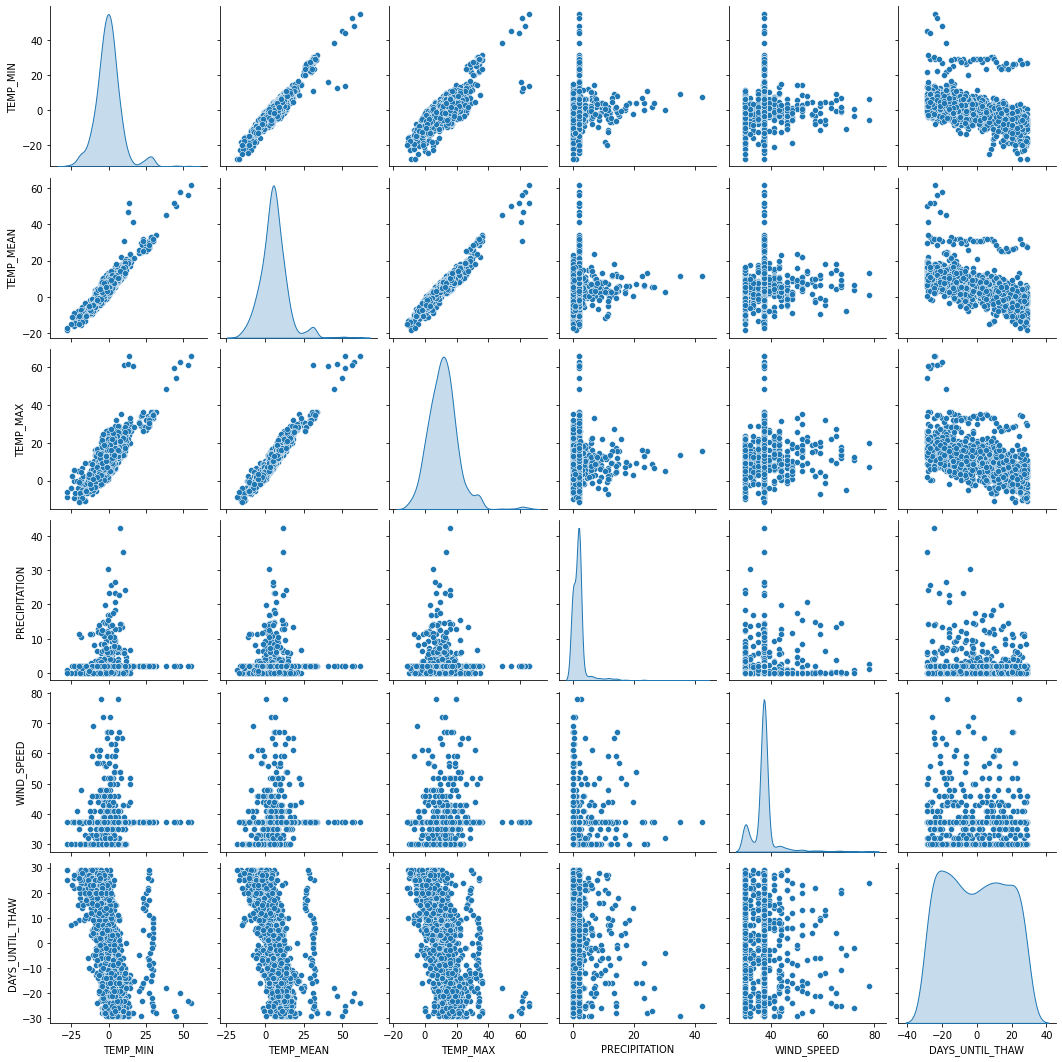

In [1137]:
## Check feature correlations
sns.pairplot(train_dataset[['TEMP_MIN', 'TEMP_MEAN', 'TEMP_MAX', 'PRECIPITATION', 'WIND_SPEED', 'DAYS_UNTIL_THAW']], diag_kind='kde')

In [1138]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,1448.0,56.184040,8.794699,45.0700,45.070000,56.650000,65.016700,65.0167
LON,1448.0,-111.281161,36.473455,-148.5833,-148.583300,-111.220000,-77.880000,-60.4200
TEMP_MAX,1381.0,11.522810,9.403826,-11.1000,5.600000,11.100000,16.100000,65.6000
TEMP_MIN,1379.0,-0.120015,8.998251,-28.0000,-5.000000,-0.600000,3.900000,55.0000
TEMP_MEAN,1379.0,5.685424,8.927581,-18.4000,0.800000,5.400000,9.400000,61.7000
PRECIPITATION,1448.0,1.955473,3.189488,0.0000,0.000000,1.955473,1.955473,42.4000
WIND_SPEED,1448.0,37.240093,5.283678,30.0000,37.240093,37.240093,37.240093,78.0000


In [1139]:
## Removing labels to be predicted
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# cols = ['TEMP_MAX','TEMP_MIN', 'TEMP_MEAN', 'DAYS_UNTIL_THAW']
cols = ['TEMP_MAX','TEMP_MIN', 'TEMP_MEAN', 'PRECIPITATION', 'DAYS_UNTIL_THAW']

train_features = train_features[cols].dropna()
test_features = test_features[cols].dropna() 

train_labels = train_features.pop('DAYS_UNTIL_THAW') 
test_labels = test_features.pop('DAYS_UNTIL_THAW') 

train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

In [1140]:
print('Before filtering: Training set size: {}. Test set size: {}.'.format(train_dataset.shape, test_dataset.shape))
print('After filtering: Training set size: {}. Test set size: {}.'.format(train_features.shape, test_features.shape))

Before filtering: Training set size: (1448, 14). Test set size: (362, 14).
After filtering: Training set size: (1379, 4). Test set size: (343, 4).


### Normalise data

In [1141]:
## Create normalisation layer
normaliser = tf.keras.layers.Normalization(axis=-1)

## Fit the state of the preprocessing layer to the data 
normaliser.adapt(np.array(train_features))

print(normaliser.mean.numpy())

[[11.527 -0.12   5.685  1.967]]


## Linear Regression
### Univariate model (TEMP_MEAN)

In [1142]:
## Normalise variable
feature_temp_mean = np.array(train_features['TEMP_MEAN'])

normaliser_temp_mean = layers.Normalization(input_shape=[1,], axis=None)
normaliser_temp_mean.adapt(feature_temp_mean)

## Build the Keras Sequential model

model_temp_mean = tf.keras.Sequential([normaliser_temp_mean,
                                       layers.Dense(units=1)])
model_temp_mean.summary()

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_45 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_233 (Dense)            (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [1143]:
## Prediction preview
model_temp_mean.predict(feature_temp_mean[:10])

array([[ 0.057],
       [ 0.362],
       [ 0.281],
       [-0.108],
       [-0.89 ],
       [-0.014],
       [ 0.133],
       [-0.466],
       [ 0.308],
       [-0.318]], dtype=float32)

In [1144]:
## Configure training procedure
model_temp_mean.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                       loss="mean_absolute_error")

In [1145]:
## Execute training for 100 epochs
history_temp_mean = model_temp_mean.fit(train_features['TEMP_MEAN'],
                                        train_labels,
                                        epochs=100,
                                        verbose=0,
                                        validation_split=0.2
                                       )

In [1146]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 20])
    plt.xlabel('Epoch')
    plt.ylabel('Error [DAYS_UNTIL_THAW]')
    plt.legend()
    plt.grid(True)

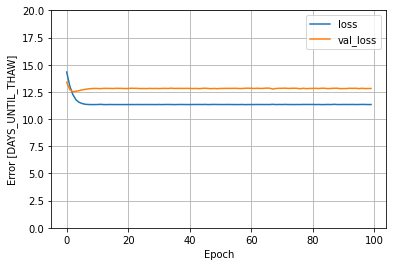

In [1147]:
plot_loss(history_temp_mean)

In [1148]:
hist = pd.DataFrame(history_temp_mean.history)
hist['epoch'] = history_temp_mean.epoch
hist.tail()

,loss,val_loss,epoch
95,11.340705,12.799656,95
96,11.346974,12.831866,96
97,11.346328,12.806833,97
98,11.334599,12.809608,98
99,11.340158,12.816341,99


In [1149]:
## Collecting test predictions for later
test_results = {}

test_results['model_temp_mean'] = model_temp_mean.evaluate(
    test_features['TEMP_MEAN'],
    test_labels, verbose=0)

In [1150]:
def plot_univariate(x, y, feature):
  plt.scatter(train_features[feature], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel(feature)
  plt.ylabel('DAYS_UNTIL_THAW')
  plt.legend()

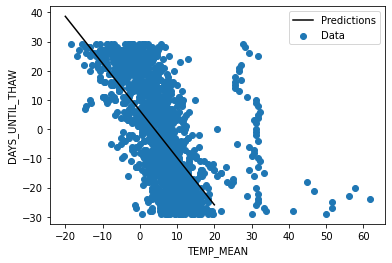

In [1151]:
x = tf.linspace(-20, 20, 10)
y = model_temp_mean.predict(x)

plot_univariate(x, y, 'TEMP_MEAN')

## Multivariate model (TEMP, PRECIPITATION)

In [1152]:
## Normaliser
linear_model = tf.keras.Sequential([
    normaliser,
    layers.Dense(units=1)
])

## Predict at a glance
linear_model.predict(train_features[:10])

## Confirm the model has the right size
linear_model.layers[1].kernel

<tf.Variable 'dense_234/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.538],
       [ 0.55 ],
       [ 0.293],
       [-0.174]], dtype=float32)>

In [1153]:
## Configure training for 100 epochs
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [1154]:
## Train the model 
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

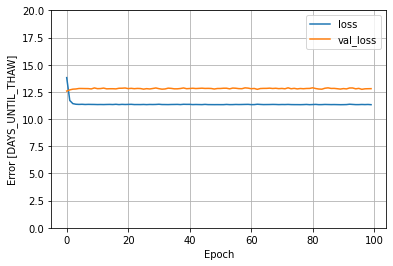

In [1155]:
plot_loss(history)

In [1156]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,11.331075,12.823354,95
96,11.342701,12.737721,96
97,11.333560,12.783331,97
98,11.344269,12.793091,98
99,11.325137,12.798030,99


In [1157]:
## Keep results for later
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Deep Neural Network

In [1269]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Single Input NN

In [1270]:
dnn_model_temp_mean = build_and_compile_model(normaliser_temp_mean)

dnn_model_temp_mean.summary()

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_45 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_295 (Dense)            (None, 64)                128       
_________________________________________________________________
dense_296 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_297 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_298 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_299 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_300 (Dense)            (None, 1)              

In [1271]:
## Train the model
history = dnn_model_temp_mean.fit(
    train_features['TEMP_MEAN'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

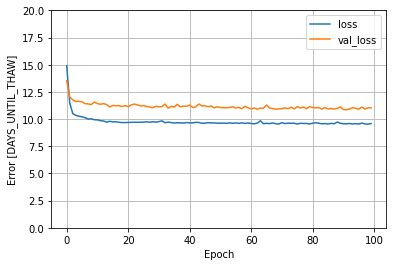

In [1272]:
plot_loss(history)

In [1273]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,9.545819,10.905137,95
96,9.628487,11.099514,96
97,9.557448,10.920921,97
98,9.532886,11.044796,98
99,9.591855,11.028515,99


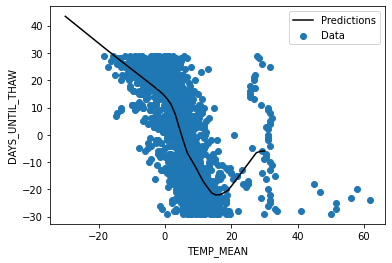

In [1274]:
x = tf.linspace(-30, 30, 50)
y = dnn_model_temp_mean.predict(x)
plot_univariate(x, y, 'TEMP_MEAN')

In [1275]:
## Collecting results for later
test_results['dnn_model_temp_mean'] = dnn_model_temp_mean.evaluate(
    test_features['TEMP_MEAN'], test_labels,
    verbose=0)

### Multiple input DNN

In [1276]:
dnn_model = build_and_compile_model(normaliser)
dnn_model.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_44 (Normalizat (None, 4)                 9         
_________________________________________________________________
dense_301 (Dense)            (None, 64)                320       
_________________________________________________________________
dense_302 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_303 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_304 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_305 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_306 (Dense)            (None, 1)              

In [1277]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

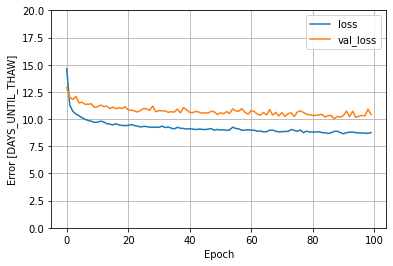

In [1278]:
plot_loss(history)

In [1279]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,8.725009,10.255980,95
96,8.724377,10.332930,96
97,8.703589,10.287893,97
98,8.687971,10.917634,98
99,8.759806,10.416301,99


In [1280]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Model performance

In [1281]:
pd.DataFrame(test_results, index=['Mean absolute error [DAYS_UNTIL_THAW]']).T

,Mean absolute error [DAYS_UNTIL_THAW]
model_temp_mean,10.794749
linear_model,10.898936
dnn_model_temp_mean,9.342289
dnn_model,9.134938


## Prediction 

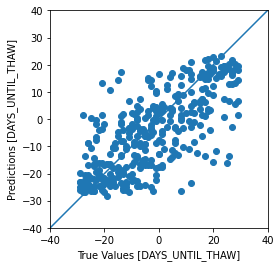

In [1282]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DAYS_UNTIL_THAW]')
plt.ylabel('Predictions [DAYS_UNTIL_THAW]')
lims = [-40, 40]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

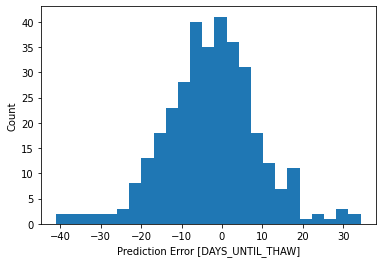

In [1283]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [DAYS_UNTIL_THAW]')
_ = plt.ylabel('Count')

### Nakagawa quiz predictions

In [1284]:
## Check recent data available for Nakagawa
df_weather_JPN['DATE'] = pd.to_datetime(df_weather_JPN['DATE'])
df_weather_JPN = df_weather_JPN.sort_values(by='DATE')
df_weather_JPN.head()

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_SPEED
Date_Day,,,,,,,,,,,
2022-1-15,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-01-15,0.0,-3.1,-0.982609,0.0,10.878261
2022-1-16,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-01-16,-0.1,-5.9,-2.733333,0.0,6.165000
2022-1-17,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-01-17,-0.3,-2.7,-1.312500,15.0,6.765000
2022-1-18,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-01-18,-2.2,-3.8,-3.070833,4.0,6.195000
2022-1-19,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-01-19,-3.1,-18.6,-8.408333,0.5,3.000000


In [ ]:
##Manually add latest data
pd.DataFrame('DATE'=')

In [1285]:
## Use only 3 most recent data
df_nakagawa = df_weather_JPN.tail(3).copy()
df_nakagawa

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_SPEED
Date_Day,,,,,,,,,,,
2022-2-22,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-02-22,-3.8,-10.9,-5.737500,0.0,14.055
2022-2-23,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-02-23,-3.8,-15.5,-9.095833,0.0,5.445
2022-2-24,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-02-24,-14.3,-14.3,-14.300000,0.0,0.360


In [1286]:
test_features_cols = ['TEMP_MAX', 'TEMP_MIN', 'TEMP_MEAN', 'PRECIPITATION']

nakagawa_test_features = df_nakagawa[test_features_cols]
nakagawa_test_features

,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION
Date_Day,,,,
2022-2-22,-3.8,-10.9,-5.737500,0.0
2022-2-23,-3.8,-15.5,-9.095833,0.0
2022-2-24,-14.3,-14.3,-14.300000,0.0


In [1287]:
df_nakagawa['DAYS_UNTIL_THAW'] = dnn_model.predict(nakagawa_test_features)

df_nakagawa['THAW_DATE'] = df_nakagawa.apply(lambda x: x.DATE + datetime.timedelta(days = x.DAYS_UNTIL_THAW), axis=1)
df_nakagawa

,COUNTRY,RIVER_CODE,STATION,LAT,LON,DATE,TEMP_MAX,TEMP_MIN,TEMP_MEAN,PRECIPITATION,WIND_SPEED,DAYS_UNTIL_THAW,THAW_DATE
Date_Day,,,,,,,,,,,,,
2022-2-22,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-02-22,-3.8,-10.9,-5.737500,0.0,14.055,18.377316,2022-03-12 09:03:20.061035
2022-2-23,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-02-23,-3.8,-15.5,-9.095833,0.0,5.445,20.011417,2022-03-15 00:16:26.462402
2022-2-24,JAPAN,TESHIO,NAKAGAWA,142.066667,44.816667,2022-02-24,-14.3,-14.3,-14.300000,0.0,0.360,24.414757,2022-03-20 09:57:14.985352


# NOTES

Random notes: 
- So far, downloaded weather data for 4 Canadian rivers (only a few years each) and 1 US river (almost 20 years worth). Also have weather data for Nakagawa and Asahikawa. 